# Importing Modules & setup

In [5]:
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from datetime import timedelta
from datetime import datetime
import scipy.stats as stats
import requests as r
import pandas as pd
import seaborn as s
import numpy as np
import postgres
import gmaps
import json
import math

import importlib
importlib.reload(postgres)

# Show all vars
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

<module 'postgres' from '/media/storage/College/S3/Github/DublinBus/Analytics/postgres.py'>

In [6]:
%%bash 
ls stored_queries/*.csv

stored_queries/combined145.csv
stored_queries/combinedbusdata.csv
stored_queries/combined.csv
stored_queries/diff1011.csv
stored_queries/distancedata.csv
stored_queries/leavetimes_Sample_Data.csv
stored_queries/query145leavetimes.csv
stored_queries/query145leavetimes_first.csv
stored_queries/query145leavetimes_full.csv
stored_queries/stop_locations.csv
stored_queries/trips_df.csv
stored_queries/vehicles_Sample_Data.csv
stored_queries/weather.csv
stored_queries/weather_darksky.csv
stored_queries/weather_phoenix_park.csv


# Importing Data

**Reading csv files**

In [7]:
leave   = pd.read_csv("stored_queries/query145leavetimes_first.csv", header=None)
# leave   = pd.read_csv("stored_queries/leavetimes_Sample_Data.csv")
weatherMET = pd.read_csv("stored_queries/weather_phoenix_park.csv")
weather = pd.read_csv("stored_queries/weather_darksky.csv")
stops   = pd.read_csv("stored_queries/stop_locations.csv")
trips   = pd.read_csv("stored_queries/trips_df.csv")

**Leavetimes Data**

In [8]:
leave.columns = ['dayofservice', 'tripid', 'progrnumber', 'stopid', 'planned_arr','planned_dep','actual_arr','actual_dep']
# leave.drop(columns=['note','updated','ix'], inplace=True);
leave.head(1)
                 
# leave.columns = ['ix','dayofservice', 'tripid', 'progrnumber', 'stopid', 'planned_arr','planned_dep','actual_arr','actual_dep','note','updated']
# leave.drop(columns=['note','updated','ix'], inplace=True);
# leave.head(1)

,dayofservice,tripid,progrnumber,stopid,planned_arr,planned_dep,actual_arr,actual_dep
0,2018-03-06,6361484,10,842,28777,28799,28994,28994


**Trips Data**

In [9]:
# trips.index.name="idx"
trips.columns = ['ix', 'dayofservice', 'tripid', 'lineid', 'routeid','direction', 'planned_arr', 'planned_dep', 'actual_arr', 'actual_dep']
trips.drop(columns=['ix'], inplace=True);
trips.head(1)

,dayofservice,tripid,lineid,routeid,direction,planned_arr,planned_dep,actual_arr,actual_dep
0,2018-06-17,7013606,7A,7A_85,1,66484,62400,67065.0,62901.0


**Stop Locations**

In [10]:
stops.columns = ['ix','actual_stop_id','stop_id','lat','lng','stop name']
stops.drop(columns=['ix'], inplace=True)
stops.head(1)

,actual_stop_id,stop_id,lat,lng,stop name
0,1965,8230DB001965,53.323868,-6.379297,Woodford Walk (Woodford Grove)


**Weather Data**

In [11]:
weather.columns = ['date_recorded','cloudCover','humidity','icon','prepIntensity','pressure','temperature','visibility','windSpeed']
weather.drop(columns=['visibility','pressure'],inplace=True)
weather.head(1)

weatherMET.columns = ['ix','station','date_recorded','rain','temperature','humidity','windspeed','winddir']
weatherMET.drop(columns=['ix', 'station','winddir'],inplace=True)
weatherMET.head(1)

,date_recorded,cloudCover,humidity,icon,prepIntensity,temperature,windSpeed
0,2018-01-01 00:00:00,0.58,0.8,partly-cloudy-night,0.0,41.19,17.04


,date_recorded,rain,temperature,humidity,windspeed
0,01/01/2018 00:00,0,4.6,82,20


# Cleaning Data

### Description of Data

<div>
<b> Description of Data </b><br>

<table style="margin-left:0px;float:left;">
<th colspan=2><b>leave Columns Desccription</b></th>
<tr>
    <td>dayofservice</td>
    <td>date of trip</td>
</tr>
<tr>
    <td>tripid</td>
    <td>identifier of trip [fk trips]</td>
</tr>
<tr>
    <td>progrnumber </td>
    <td>The sequential position of the route in the journey.</td>
</tr>
<tr>
    <td>stopid</td>
    <td>stop number</td>
</tr>
<tr>
    <td>planned_arr</td>
    <td>planned time of arrival at the stop</td>
</tr>
<tr>
    <td>planned_dep</td>
    <td>planned time of departure from stop</td>
</tr>
<tr>
    <td>actual_arr</td>
    <td>actual time of arrival at the stop</td>
</tr>
<tr>
    <td>actual_dep</td>
    <td>actual time of departure from stop</td>
</tr>
<tr>
    <td>distance</td>
    <td>distance travelled up to this point in the journey</td>
</tr>
</table>


<table style="margin-left:15px;float:left;">
<th colspan=2><b>Trips Columns Desccription</b></th>
<tr>
    <td>dayofservice</td>
    <td>date of trip</td>
</tr>
<tr>
    <td>tripid</td>
    <td>identifier of trip</td>
</tr>
<tr>
    <td>lineid</td>
    <td>bus route id/name</td>
</tr>
<tr>
    <td>routeid</td>
    <td>Unique route identifier [change with stop changes for line number]</td>
</tr>
<tr>
    <td>direction</td>
    <td>Forward or backward journey</td>
</tr>
<tr>
    <td>planned_arr</td>
    <td>planned time of arrival at end</td>
</tr>
<tr>
    <td>planned_dep</td>
    <td>planned time of departure from start</td>
</tr>
<tr>
    <td>actual_arr</td>
    <td>actual time of arrival at end</td>
</tr>
<tr>
    <td>actual_dep</td>
    <td>actual time of departure from start</td>
</tr>
</table>

<table style="margin-left:15px;float:left;">
<th colspan=2><b>Stops Columns Desccription</b></th>
<tr>
    <td>actual_stop_id</td>
    <td>Stop Number</td>
</tr>
<tr>
    <td>stop_id</td>
    <td>full identifier of stop</td>
</tr>
<tr>
    <td>lat</td>
    <td>latitude</td>
</tr>
<tr>
    <td>lng</td>
    <td>longitude</td>
</tr>
<tr>
    <td>stop name</td>
    <td>address of stop</td>
</tr>
</table>

<table style="margin-left:15px;float:left;">
<th colspan=2><b>Weather Columns Desccription</b></th>
<tr>
    <td>cloudCover</td>
    <td>The percentage of sky occluded by clouds, between 0 and 1, inclusive</td>
</tr>
<tr>
    <td>humidity</td>
    <td>The relative humidity, between 0 and 1, inclusive.</td>
</tr>
<tr>
    <td>icon</td>
    <td>One of : 'partly-cloudy-night', 'partly-cloudy-day', 'rain', 'wind',
       'cloudy', 'fog', 'clear-night', 'clear-day'</td>
</tr>
<tr>
    <td>prepIntensity</td>
    <td>The intensity (in inches of liquid water per hour) of precipitation occurring at the given time. <br>This value is conditional on probability (that is, assuming any precipitation occurs at all).</td>
</tr>
<tr>
    <td>pressure</td>
    <td>The sea-level air pressure in millibars.</td>
</tr>
<tr>
    <td>temperature	</td>
    <td>The air temperature in degrees Fahrenheit</td>
</tr>
<tr>
    <td>windSpeed</td>
    <td>The wind speed in miles per hour.</td>
</tr>

</table>
</div>

**Notes on Data**

Leavetimes Table: 
- There are 4774 distinct stop ids
- There dates run between 01/01/18 and 31/12/18
- Tripid is not unique to a single bus journey but rather a specific route taken by the bus.
- Progrnumber has min value 1 and max value of 109 indicating there are no more than 109 stops in any given route
- All time columns may go over the 86400 mark indicating they have pushed over into the next day. $ t \in [16200, 91680]$
- distance may be useful - unsure yet. If a graph structure is made of the connected stops the distance between a given two could be useful. 

Trips Table:
- lineid does not contain all the bus routes [17, 175, etc not included]
- routeid needs more attention 
- direction which way its going along the route - this is useless as the distance between stops is route agnostic
- times can go beyond 86400 if trips take extra long. 

Stops Table:
- actual_stop_id may be useful - need to link it to stoppointid from the leave times table
- lat,lng are very useful. 
- stop names are probably useless [other that front end use]

Weather Table:
- missing a rake of data - Not sure how to rectify this yet. Maybe need to use the met eireann data where there arent missing values ?? 
- Have currently put in the wrong data but this may be an issue. 

### Weather Table

#### Setting Data Types

In [12]:
weather.dtypes
weatherMET.dtypes

date_recorded     object
cloudCover       float64
humidity         float64
icon              object
prepIntensity    float64
temperature      float64
windSpeed        float64
dtype: object

date_recorded     object
rain              object
temperature      float64
humidity           int64
windspeed          int64
dtype: object

In [13]:
weatherMET.date_recorded = pd.to_datetime(weatherMET.date_recorded)
weather.date_recorded= pd.to_datetime(weather.date_recorded)

In [14]:
print("icon Values")
weather.icon.unique()

icon Values


array(['partly-cloudy-night', 'partly-cloudy-day', 'rain', 'wind',
       'cloudy', 'fog', 'clear-night', 'clear-day'], dtype=object)

In [15]:
weather.icon = weather.icon.astype('category');

#### Altering Columns

In [16]:
weather.columns

Index(['date_recorded', 'cloudCover', 'humidity', 'icon', 'prepIntensity',
       'temperature', 'windSpeed'],
      dtype='object')

In [17]:
# change date time to a date and an hour column
weather['hour'] = weather.date_recorded.dt.hour
weather['dayofservice'] = weather.date_recorded.dt.date
weather.drop(columns=['date_recorded'], inplace=True);
weather = weather[['dayofservice','hour','icon','temperature','humidity','cloudCover','prepIntensity','windSpeed']]

weatherMET['hour'] = weatherMET.date_recorded.dt.hour
weatherMET['dayofservice'] = weatherMET.date_recorded.dt.date
weatherMET.drop(columns=['date_recorded'], inplace=True);

In [18]:
weather.drop(columns=['prepIntensity'], inplace=True);

In [19]:
Join_weather_data = weatherMET[['dayofservice','hour','rain']]
weather = weather.merge(Join_weather_data, how='left', on=['dayofservice','hour']);
weather.head()

,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain
0,2018-01-01,0,partly-cloudy-night,41.19,0.80,0.58,17.04,0
1,2018-01-01,1,partly-cloudy-night,41.70,0.79,0.75,21.59,0.1
2,2018-01-01,2,partly-cloudy-night,41.95,0.78,0.75,21.59,0
3,2018-01-01,3,partly-cloudy-night,42.42,0.82,0.58,19.60,0
4,2018-01-01,4,partly-cloudy-night,42.09,0.83,0.44,20.48,0


In [20]:
weather.rain.unique()
weather.rain.loc[6220:6225]

array(['0', '0.1', '0.2', '0.8', '0.4', '1.2', '0.3', '0.6', '1', '2',
       '1.1', '0.7', '1.4', '0.9', '0.5', '1.6', '2.4', '1.5', '2.3',
       '2.1', '1.8', '1.9', '3', '5.2', '2.8', '1.3', '1.7', '2.2', '3.7',
       '3.2', '2.5', '3.3', '3.8', '3.6', '8.6', '2.9', '3.5', '2.6',
       '6.2', '4.1', ' ', '2.7', '3.4', '4.7', '7.5'], dtype=object)

6220    0
6221     
6222     
6223    0
6224    0
6225    0
Name: rain, dtype: object

In [21]:
# replce missing with zeros
weather.rain.replace(' ', 0, inplace=True)
weather.rain = weather.rain.astype(float)

In [22]:
weather.dayofservice = pd.to_datetime(weather.dayofservice)

In [23]:
weather.to_csv('stored_queries/weather.csv', index=False)

#### Looking for Null / Missing / Duplicated Data

In [24]:
weather_count = pd.DataFrame([weather.count(), weather.isnull().sum()]).transpose()
weather_count.columns=['NonNull','Null']
weather_count['PctNull'] = round(100 * weather_count.Null / (weather_count.NonNull + weather_count.Null),2)
weather_count

,NonNull,Null,PctNull
dayofservice,8751,0,0.00
hour,8751,0,0.00
icon,8751,0,0.00
temperature,8751,0,0.00
humidity,8751,0,0.00
cloudCover,8496,255,2.91
windSpeed,8745,6,0.07
rain,8751,0,0.00


#### Handling Missing/ Null/ Duplicated Data

##### CloudCover Column

<Figure size 2160x360 with 0 Axes>

(4000, 4500)

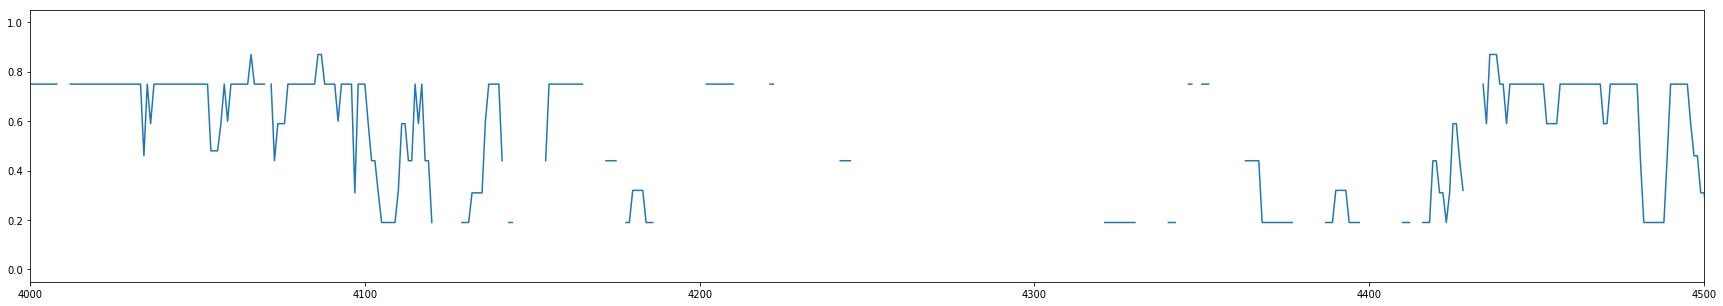

In [25]:
plt.figure(figsize=(30 ,5))
plt.plot(weather.cloudCover)
plt.xlim([4000,4500])

In [26]:
ser = weather.cloudCover

for row in tnrange(len(ser.index)):
    
    if pd.isnull(ser.iloc[row]):
        
        i=1
        j=1
        
        while pd.isnull(ser.iloc[row]):
            
            if not (pd.isnull(ser.iloc[row-i]) and pd.isnull(ser.iloc[row+j])):
                ser.iloc[row] = (ser.iloc[row-i]+ser.iloc[row+j])/2
            
            elif not pd.isnull(ser.iloc[row-i]):
                ser.iloc[row] = ser.iloc[row-i]
                i+=1
                continue
                
            elif not pd.isnull(ser.iloc[row+j]):
                ser.iloc[row] = ser.iloc[row+j]
                j+=1
                continue
                
            j+=1
            i+=1

<Figure size 2160x360 with 0 Axes>

(4000, 4500)

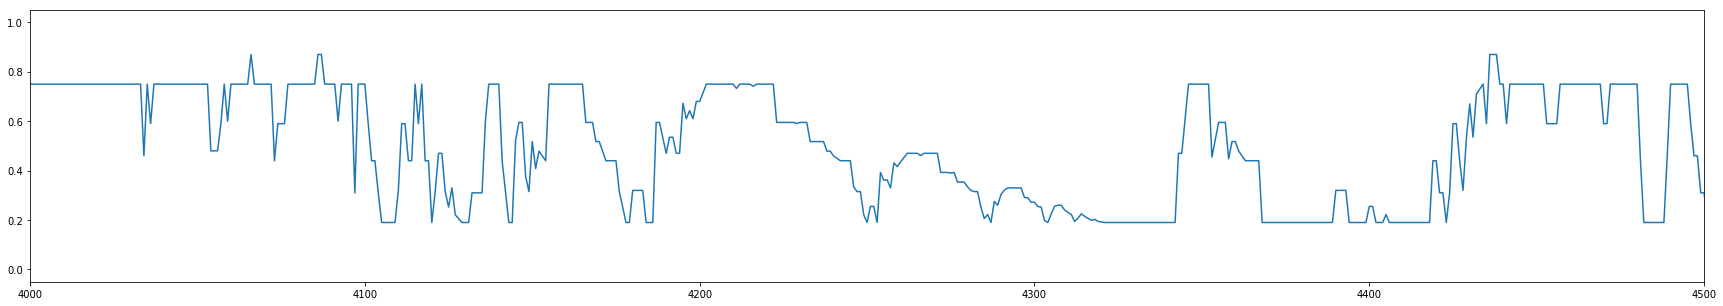

In [27]:
plt.figure(figsize=(30 ,5))
plt.plot(ser)
plt.xlim([4000,4500])

### Leave Times Table

#### Setting Data Types

In [28]:
leave.dtypes

dayofservice    object
tripid           int64
progrnumber      int64
stopid           int64
planned_arr      int64
planned_dep      int64
actual_arr       int64
actual_dep       int64
dtype: object

In [29]:
leave.dayofservice = pd.to_datetime(leave.dayofservice.iloc[:])
leave.planned_arr = pd.to_datetime(leave.planned_arr.iloc[:])
leave.planned_dep = pd.to_datetime(leave.planned_dep.iloc[:])
leave.actual_arr = pd.to_datetime(leave.actual_arr.iloc[:])
leave.actual_dep = pd.to_datetime(leave.actual_dep.iloc[:])

#### Looking for Null / Missing / Duplicated Data

In [30]:
# Note this is just on a subset of the actual data
leave_count = pd.DataFrame([leave.count(), leave.isnull().sum()]).transpose()
leave_count.columns=['NonNull','Null']
leave_count['PctNull'] = round(100 * leave_count.Null / (leave_count.NonNull + leave_count.Null),2)
leave_count

,NonNull,Null,PctNull
dayofservice,9951765,0,0.0
tripid,9951765,0,0.0
progrnumber,9951765,0,0.0
stopid,9951765,0,0.0
planned_arr,9951765,0,0.0
planned_dep,9951765,0,0.0
actual_arr,9951765,0,0.0
actual_dep,9951765,0,0.0


In [31]:
leave["is_duplicated"]=leave.duplicated(subset=['dayofservice', 'tripid', 'progrnumber'], keep=False)

In [32]:
# leave[leave.is_duplicated==True].groupby(by=['dayofservice', 'tripid', 'progrnumber']).head()

#### Handling Missing/ Null/ Duplicated Data

In [33]:
# None detected

### Trips Table

#### Setting Data Types

Want to delete the rows with missing values.<br> However, Need to check if there are 
any tripids in the leavetimes table that have a linked lineid in trips first. 
If no links are found, then there rows will be deleted. <br>
=> links found => fuck

In [34]:
trips.dtypes

dayofservice     object
tripid            int64
lineid           object
routeid          object
direction         int64
planned_arr       int64
planned_dep       int64
actual_arr      float64
actual_dep      float64
dtype: object

In [35]:
list(trips.lineid.unique()[:10])
list(trips.routeid.unique()[:5])


['7A', '41C', '31', '67', '44', '27', '53', '4', '65B', '140']

['7A_85', '41C_79', '31_15', '67_6', '44_36']

In [36]:
trips.dayofservice = pd.to_datetime(trips.dayofservice.iloc[:])
trips.lineid = trips.lineid.astype('category');
trips.routeid= trips.routeid.astype('category');

#### Looking for Null / Missing / Duplicated Data

In [37]:
print(f"No. Null actual_arr and actual_dep: {trips[trips.actual_arr.isnull() & trips.actual_dep.isnull()].isnull().sum()['actual_arr']}")
print(f"No. Null actual_arr or  actual_dep: {trips[trips.actual_arr.isnull() | trips.actual_dep.isnull()].isnull().sum().max()}")
print(f"No. Null actual_arr: {trips[trips.actual_arr.isnull()].isnull().sum()['actual_arr']}")
print(f"No. Null actual_dep: {trips[trips.actual_dep.isnull()].isnull().sum()['actual_dep']}")

trips_count = pd.DataFrame([trips.count(), trips.isnull().sum()]).transpose()
trips_count.columns=['NonNull','Null']
trips_count['PctNull'] = round(100 * trips_count.Null / (trips_count.NonNull + trips_count.Null),2)
trips_count

No. Null actual_arr and actual_dep: 12488
No. Null actual_arr or  actual_dep: 164551
No. Null actual_arr: 137207
No. Null actual_dep: 164551


,NonNull,Null,PctNull
dayofservice,2182637,0,0.00
tripid,2182637,0,0.00
lineid,2182637,0,0.00
routeid,2182637,0,0.00
direction,2182637,0,0.00
planned_arr,2182637,0,0.00
planned_dep,2182637,0,0.00
actual_arr,2045430,137207,6.29
actual_dep,2018086,164551,7.54


#### Handling Missing/ Null/ Duplicated Data

**Given that its stop to stop times being modeled. It should be fine to drop the time columns from trips.**

In [38]:
trips.drop(columns=['planned_arr', 'planned_dep', 'actual_arr', 'actual_dep'], inplace=True)
trips.head(1)

,dayofservice,tripid,lineid,routeid,direction
0,2018-06-17,7013606,7A,7A_85,1


### Stops Table

#### Setting Data Types

In [39]:
stops.dtypes

actual_stop_id     object
stop_id            object
lat               float64
lng               float64
stop name          object
dtype: object

In [40]:
stops.actual_stop_id.unique()
list(stops.stop_id.unique()[:5])
list(stops['stop name'].unique()[:5])

array(['1965', '1112', '318', ..., '7015', '7016', '3370'], dtype=object)

['8230DB001965',
 '8230DB001112',
 '8220DB000318',
 '8230DB000100',
 '8220DB002396']

['Woodford Walk (Woodford Grove)',
 'Whitehall Park',
 "Westmoreland Street (O'Connell Bridge)",
 'Wellington Lane (Wellington Green',
 'Wainsfort Estate']

In [41]:
# replace errors and drop nas to set data type as int
stops.actual_stop_id = stops.actual_stop_id[~stops.actual_stop_id.str.contains(':')]
stops = stops.dropna()
stops.actual_stop_id = stops.actual_stop_id.astype(int)

In [42]:
stops.stop_id = stops.stop_id.astype(str)
stops['stop name']=stops['stop name'].astype(str)

In [43]:
stops.dtypes

actual_stop_id      int64
stop_id            object
lat               float64
lng               float64
stop name          object
dtype: object

#### Looking for Null / Missing / Duplicated Data

In [44]:
stops_count = pd.DataFrame([stops.count(), stops.isnull().sum()]).transpose()
stops_count.columns=['NonNull','Null']
stops_count['PctNull'] = round(100 * stops_count.Null / (stops_count.NonNull + stops_count.Null),2)
stops_count

,NonNull,Null,PctNull
actual_stop_id,4228,0,0.0
stop_id,4228,0,0.0
lat,4228,0,0.0
lng,4228,0,0.0
stop name,4228,0,0.0


### Matching up tables

In [45]:
leave.head()
weather.head(24)


,dayofservice,tripid,progrnumber,stopid,planned_arr,planned_dep,actual_arr,actual_dep,is_duplicated
0,2018-03-06,6361484,10,842,1970-01-01 00:00:00.000028777,1970-01-01 00:00:00.000028799,1970-01-01 00:00:00.000028994,1970-01-01 00:00:00.000028994,True
1,2018-03-06,6361484,32,2014,1970-01-01 00:00:00.000030360,1970-01-01 00:00:00.000030374,1970-01-01 00:00:00.000030601,1970-01-01 00:00:00.000030601,True
2,2018-03-06,6361484,51,4124,1970-01-01 00:00:00.000031530,1970-01-01 00:00:00.000031543,1970-01-01 00:00:00.000031672,1970-01-01 00:00:00.000031672,True
3,2018-03-06,6361484,20,760,1970-01-01 00:00:00.000029478,1970-01-01 00:00:00.000029504,1970-01-01 00:00:00.000029797,1970-01-01 00:00:00.000029797,True
4,2018-03-06,6361484,40,3129,1970-01-01 00:00:00.000030870,1970-01-01 00:00:00.000030893,1970-01-01 00:00:00.000031099,1970-01-01 00:00:00.000031099,True


,dayofservice,hour,icon,temperature,humidity,cloudCover,windSpeed,rain
0,2018-01-01,0,partly-cloudy-night,41.19,0.80,0.58,17.04,0.0
1,2018-01-01,1,partly-cloudy-night,41.70,0.79,0.75,21.59,0.1
2,2018-01-01,2,partly-cloudy-night,41.95,0.78,0.75,21.59,0.0
3,2018-01-01,3,partly-cloudy-night,42.42,0.82,0.58,19.60,0.0
4,2018-01-01,4,partly-cloudy-night,42.09,0.83,0.44,20.48,0.0
5,2018-01-01,5,partly-cloudy-night,42.59,0.77,0.75,17.89,0.0
6,2018-01-01,6,partly-cloudy-night,41.94,0.78,0.75,12.31,0.0
7,2018-01-01,7,partly-cloudy-night,41.19,0.81,0.75,9.60,0.0
8,2018-01-01,8,partly-cloudy-night,41.19,0.81,0.75,11.27,0.0
9,2018-01-01,9,partly-cloudy-day,41.19,0.81,0.49,12.91,0.0


### Summary

# Investigating features

## Correlation plots

In [46]:
corr = leave.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,tripid,progrnumber,stopid,is_duplicated
tripid,1,0.0012,0.011,0.0064
progrnumber,0.0012,1,0.036,-0.0039
stopid,0.011,0.036,1,-0.00082
is_duplicated,0.0064,-0.0039,-0.00082,1


## Box plots for categorical features

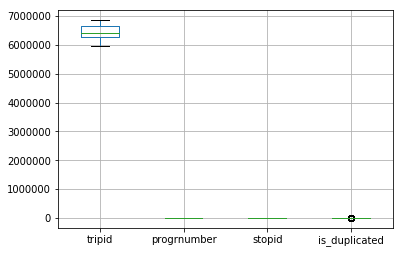

In [49]:
leave.boxplot()

## Combining Features

In [122]:
# Are there any features which can be combined to create a better explanatory variable.